In [51]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils.data import get_hsm_dataset, get_solar_energy_dataset, get_fuel_prices_dataset, get_passengers_dataset, log_returns
from utils.visualization import visualization

In [52]:
hsm_dataset_dir = Path("data/huge_stock_market_dataset/")
se_dataset_dir = Path("data/solar_energy/")
fp_dataset_dir = Path("data/fuel_prices/")
ap_dataset_dir = Path("data/air_passengers/")
results_dir = Path("results")

In [53]:
hsm_info = pd.read_csv(hsm_dataset_dir / "selected100.csv")
hsm_info["ts_id"] = hsm_info.index

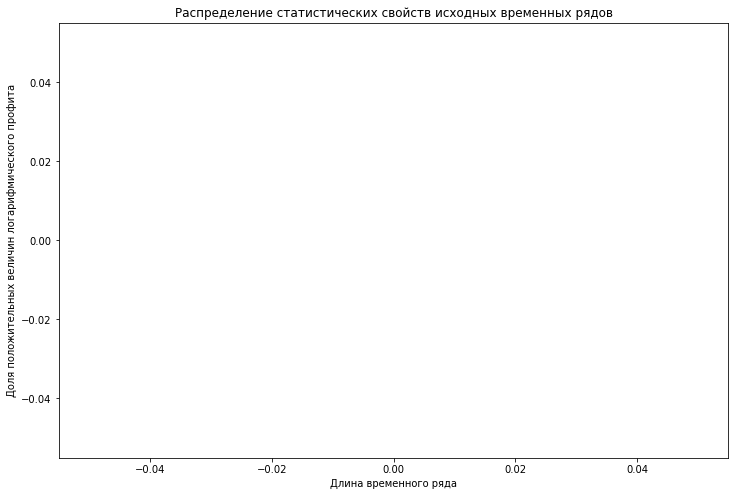

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(hsm_info["length"], y=hsm_info["uptrending_rate"], ax=ax)
ax.set_xlabel("Длина временного ряда")
ax.set_ylabel("Доля положительных величин логарифмического профита")
ax.set_title("Распределение статистических свойств исходных временных рядов")
plt.show()

In [55]:
results = []
for results_type in ("real", "QuantGAN", "FourierFlow", "RealNVP", "TTS_GAN"):
    for model in ("LSTM", "TCN"):#, "CBR"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if results_type == "real":
                df = pd.read_csv(results_dir / f"{results_type}_{dataset_name}_{model}.csv")
            else:
                df = pd.read_csv(results_dir / f"synth_{results_type}_{dataset_name}_{model}.csv")
            df["model"] = model
            df["results_type"] = results_type
            df["dataset"] = dataset_name
            results.append(df)
results = pd.concat(results)
# results["model"].replace("CBR", "CatBoostRegressor", inplace=True)
# results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
#                                 ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
#                                 inplace=True)
results

,test,model,results_type,dataset
0,0.415065,LSTM,real,hsm
1,0.567788,LSTM,real,hsm
2,0.680561,LSTM,real,hsm
3,0.825972,LSTM,real,hsm
4,0.410212,LSTM,real,hsm
...,...,...,...,...
45,0.840568,TCN,TTS_GAN,ap
46,0.776409,TCN,TTS_GAN,ap
47,0.848419,TCN,TTS_GAN,ap
48,0.791869,TCN,TTS_GAN,ap


In [56]:
results_agg = results.groupby(by=["model", "results_type", "dataset"], axis=0, as_index=False).agg(test=("test", "mean"))
results_agg

,model,results_type,dataset,test
0,LSTM,FourierFlow,ap,0.960249
1,LSTM,FourierFlow,fp,0.693573
2,LSTM,FourierFlow,hsm,0.606643
3,LSTM,FourierFlow,se,0.390937
4,LSTM,QuantGAN,ap,0.677491
5,LSTM,QuantGAN,fp,0.798805
6,LSTM,QuantGAN,hsm,0.712685
7,LSTM,QuantGAN,se,0.410153
8,LSTM,RealNVP,ap,6.713808
9,LSTM,RealNVP,fp,0.598064


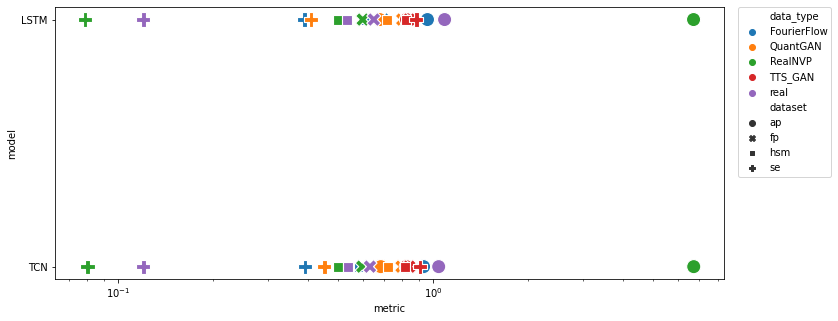

In [57]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(x=results_agg["test"].rename("metric"), y=results_agg["model"], 
    hue=results_agg["results_type"].rename("data_type"), style=results_agg["dataset"], s=200, ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xscale("log")
plt.show()

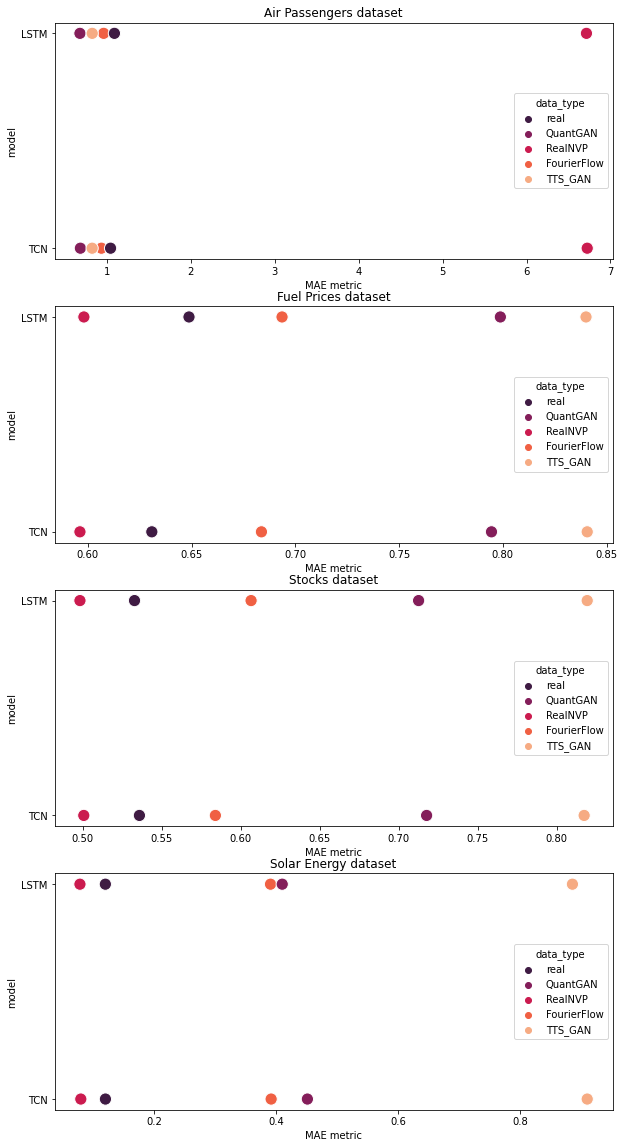

In [58]:
fig, axs = plt.subplots(4, figsize=(10, 20))
for i, dataset_name in enumerate(results_agg.dataset.unique()):
    loc_res = results_agg[results_agg.dataset == dataset_name]
    sns.scatterplot(x=loc_res["test"].rename("MAE metric"), y=loc_res["model"], hue=loc_res["results_type"].rename("data_type"),
     hue_order=("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"), ax=axs[i], s=150, palette="rocket")
    axs[i].set_title({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}[dataset_name] + " dataset")

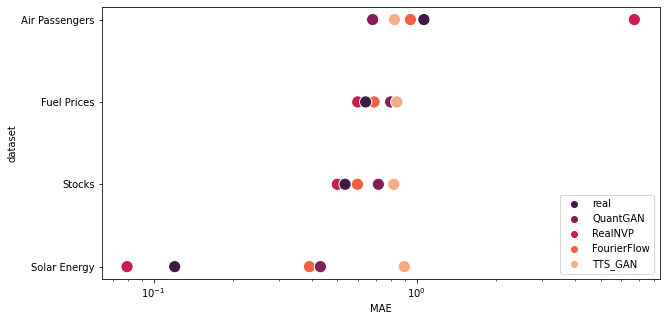

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
advanced_results_agg = results_agg.groupby(["dataset", "results_type"], as_index=False).agg(MAE=("test", "mean"))
sns.scatterplot(data=advanced_results_agg, x="MAE", y=advanced_results_agg["dataset"]\
    .replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
    hue="results_type",\
    hue_order=("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"), ax=ax, s=150, palette="rocket")
ax.legend(bbox_to_anchor=(0.99, 0.02), loc='lower right', borderaxespad=0)
plt.xscale("log")
plt.show()

c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


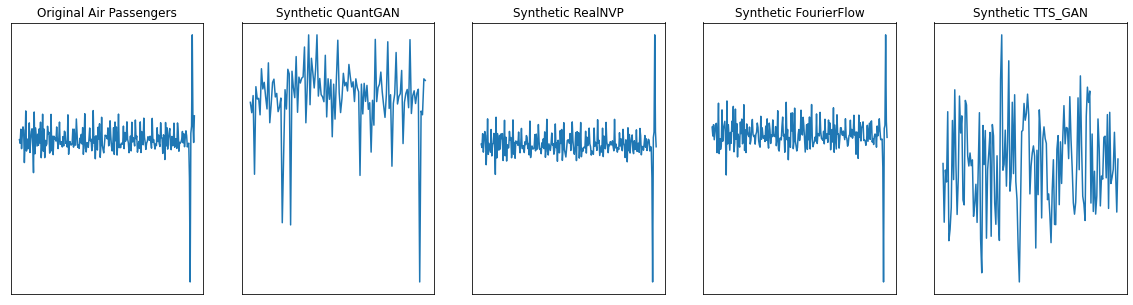

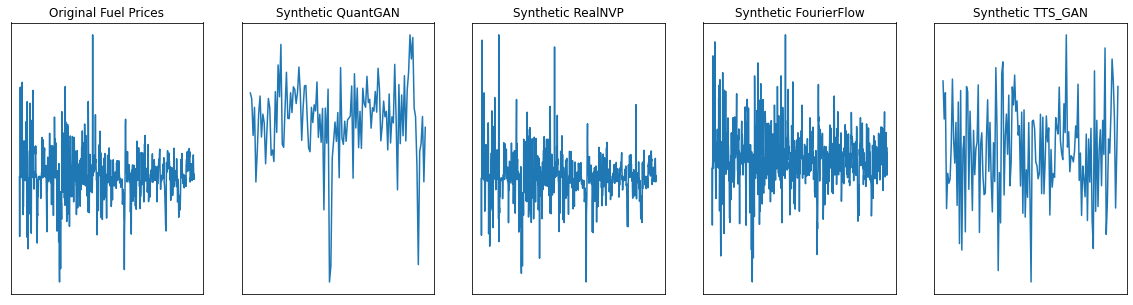

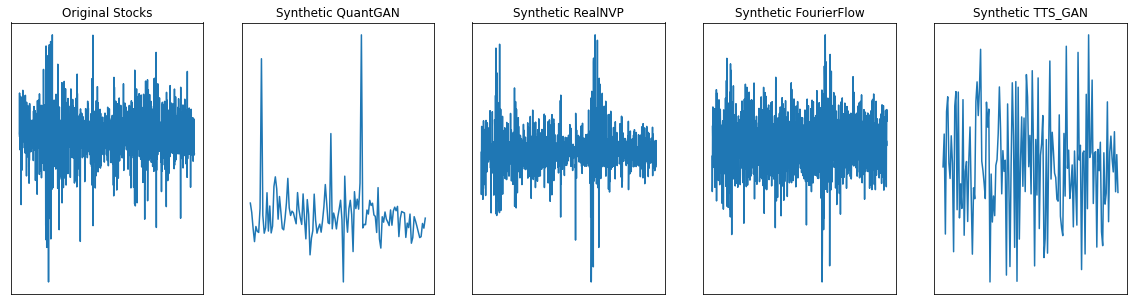

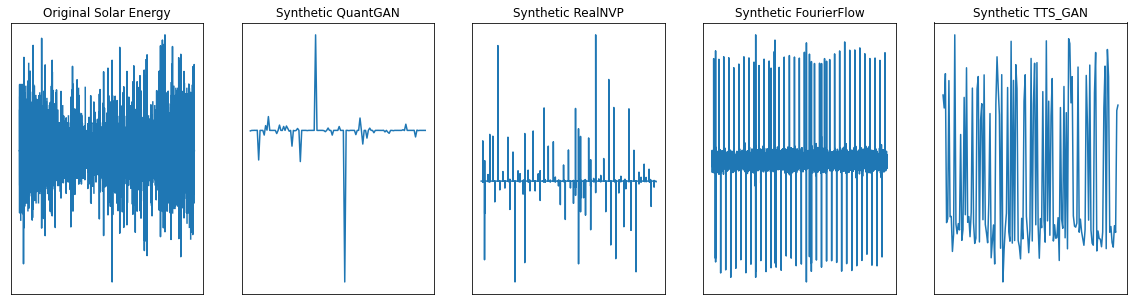

In [60]:
for dataset_name, dataset_dir, dataset_func in (
    ("Air Passengers", ap_dataset_dir, get_passengers_dataset),
    ("Fuel Prices", fp_dataset_dir, get_fuel_prices_dataset),
    ("Stocks", hsm_dataset_dir, get_hsm_dataset),
    ("Solar Energy", se_dataset_dir, get_solar_energy_dataset)
):
    time_series = next(dataset_func(dataset_dir))

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].plot(log_returns(time_series))
    axs[0].set_title(f"Original {dataset_name}")
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)
    for i, model_name in zip(range(1, 5), ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN")):
        synth_time_series = np.load(dataset_dir / f"synthetic/{model_name}/selected0.npy")
        axs[i].plot(synth_time_series[0].flatten())
        axs[i].set_title(f"Synthetic {model_name}")
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
plt.show()

# Synthetic similarity results

In [61]:
results = []
for model in ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
    for dataset_name in ("hsm", "se", "fp", "ap"):
        df = pd.read_csv(results_dir / f"synth_{dataset_name}_sim_{model}.csv").rename(columns={"sj_div": "js_div"})
        results.append({"model": model, "dataset": dataset_name,
        "kl_div": df["kl_div"].mean(), "js_div": df["js_div"].mean()})
synth_sim_results = pd.DataFrame(results).replace({1: 0.02203})
synth_sim_results

,model,dataset,kl_div,js_div
0,QuantGAN,hsm,0.067871,0.018197
1,QuantGAN,se,0.093906,0.025480
2,QuantGAN,fp,0.098727,0.023304
3,QuantGAN,ap,0.088096,0.022030
4,RealNVP,hsm,0.007549,0.001956
5,RealNVP,se,0.020123,0.005023
6,RealNVP,fp,0.024043,0.005945
7,RealNVP,ap,0.100823,0.026480
8,FourierFlow,hsm,0.004134,0.001057
9,FourierFlow,se,0.000460,0.000114


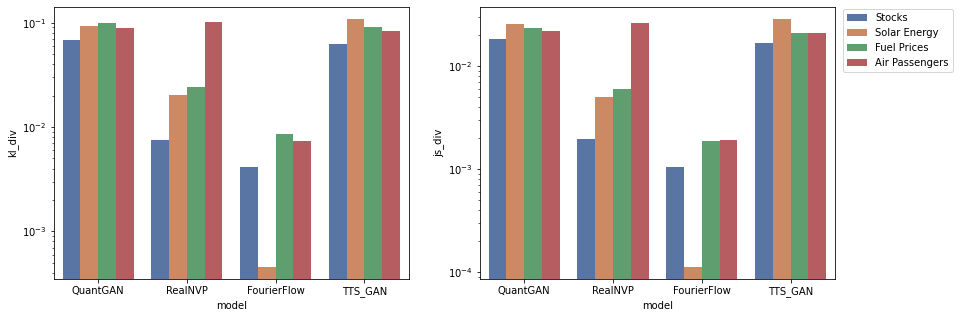

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric_name in enumerate(("kl_div", "js_div")):
    sns.barplot(x=synth_sim_results["model"], y=synth_sim_results[metric_name], 
        hue=synth_sim_results["dataset"].replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
             ax=axs[i], palette="deep")
    axs[i].set_yscale("log")
axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.01, 1.01))
plt.show()

In [63]:
dfs = {}
for res_type in ("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
    for model in ("LSTM", "TCN"):#, "CBR"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if res_type == "real":
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"{res_type}_{dataset_name}_{model}.csv")["test"]
            else:
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"synth_{res_type}_{dataset_name}_{model}.csv")["test"]
results = pd.DataFrame(dfs)
results

,real_LSTM_hsm,real_LSTM_se,real_LSTM_fp,real_LSTM_ap,real_TCN_hsm,real_TCN_se,real_TCN_fp,real_TCN_ap,QuantGAN_LSTM_hsm,QuantGAN_LSTM_se,...,FourierFlow_TCN_fp,FourierFlow_TCN_ap,TTS_GAN_LSTM_hsm,TTS_GAN_LSTM_se,TTS_GAN_LSTM_fp,TTS_GAN_LSTM_ap,TTS_GAN_TCN_hsm,TTS_GAN_TCN_se,TTS_GAN_TCN_fp,TTS_GAN_TCN_ap
0,0.415065,0.136675,0.459725,0.924060,0.403304,0.136627,0.463209,0.803021,0.595673,0.253133,...,0.543971,0.827822,0.781667,0.869790,0.858184,0.796087,0.783670,0.915316,0.856037,0.787671
1,0.567788,0.139915,0.440980,0.882098,0.569937,0.140487,0.433294,0.884818,0.700988,1.117416,...,0.540320,0.858123,0.797264,0.836445,0.871629,0.822556,0.798814,0.886362,0.866550,0.825550
2,0.680561,0.111841,0.631747,1.273527,0.694972,0.111904,0.629654,1.448951,0.755984,0.227144,...,0.655193,1.197845,0.865710,0.913982,0.844686,0.831953,0.864760,0.945612,0.849616,0.830759
3,0.825972,0.110642,0.382098,1.929218,0.802282,0.110606,0.380874,1.911595,0.738591,0.389470,...,0.555798,0.876510,0.712105,0.995523,0.805980,0.809388,0.716725,1.006423,0.811224,0.806813
4,0.410212,0.111111,0.786535,0.636217,0.404704,0.111037,0.764337,0.652330,0.576576,0.285137,...,0.732164,0.824614,0.869672,0.922551,0.858033,0.843782,0.864794,0.921938,0.851469,0.843180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.680089,NaN,NaN,NaN,0.648382,NaN,NaN,NaN,0.708613,NaN,...,NaN,NaN,0.832135,NaN,NaN,NaN,0.825599,NaN,NaN,NaN
96,1.059702,NaN,NaN,NaN,1.040683,NaN,NaN,NaN,0.703835,NaN,...,NaN,NaN,0.825679,NaN,NaN,NaN,0.826824,NaN,NaN,NaN
97,0.429882,NaN,NaN,NaN,0.435115,NaN,NaN,NaN,0.638825,NaN,...,NaN,NaN,0.808820,NaN,NaN,NaN,0.809464,NaN,NaN,NaN
98,0.449148,NaN,NaN,NaN,0.453674,NaN,NaN,NaN,0.575982,NaN,...,NaN,NaN,0.794908,NaN,NaN,NaN,0.793913,NaN,NaN,NaN


In [64]:
corrs = []
ds_lens = {"hsm": 100, "se": 10, "fp": 8, "ap": 50}
for model in ("LSTM", "TCN"):#, "CBR"):
    for res_type in ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            # correlation
            res = np.corrcoef([results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]],
                results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]]])[0][1]
            z = 0.5 * np.log((1 + res) / (1 - res))
            SE =  1 / (ds_lens[dataset_name] - 3) ** 0.5
            zl, zh = z - 1.96 * SE, z + 1.96 * SE
            lb, hb = ((np.e ** (2 * zl) - 1) / (np.e ** (2 * zl) + 1), (np.e ** (2 * zh) - 1) / (np.e ** (2 * zh) + 1))
            corrs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "correlation": res,\
                "low_bound": lb, "high_bound": hb})
corrs = pd.DataFrame(corrs)
corrs

,model,synth_model,dataset,correlation,low_bound,high_bound
0,LSTM,QuantGAN,hsm,0.281451,0.090005,0.452838
1,LSTM,QuantGAN,se,0.481261,-0.212880,0.852556
2,LSTM,QuantGAN,fp,0.564425,-0.232883,0.907970
3,LSTM,QuantGAN,ap,-0.148781,-0.410148,0.135169
4,LSTM,RealNVP,hsm,0.980607,0.971263,0.986933
5,LSTM,RealNVP,se,0.223512,-0.472637,0.747895
6,LSTM,RealNVP,fp,0.896838,0.522144,0.981332
7,LSTM,RealNVP,ap,0.858341,0.762061,0.917486
8,LSTM,FourierFlow,hsm,0.922586,0.886882,0.947336
9,LSTM,FourierFlow,se,-0.298891,-0.781461,0.407416


In [65]:
corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()
corrs_agg

C:\Users\Владислав\AppData\Local\Temp/ipykernel_16436/2987291452.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()


,dataset,synth_model,correlation,low_bound,high_bound
0,ap,FourierFlow,0.650269,0.454232,0.786258
1,ap,QuantGAN,-0.151780,-0.412694,0.132154
2,ap,RealNVP,0.849925,0.748740,0.912409
3,ap,TTS_GAN,0.023983,-0.256074,0.300325
4,fp,FourierFlow,0.947407,0.730671,0.990683
5,fp,QuantGAN,0.561804,-0.236499,0.907293
6,fp,RealNVP,0.896332,0.520268,0.981236
7,fp,TTS_GAN,-0.121288,-0.760914,0.637885
8,hsm,FourierFlow,0.923640,0.888393,0.948061
9,hsm,QuantGAN,0.268994,0.076656,0.442034


<AxesSubplot:xlabel='synth_model', ylabel='correlation'>

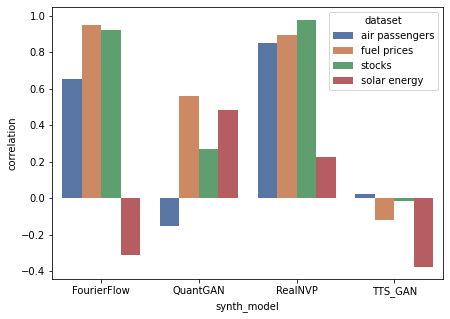

In [66]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=corrs_agg["synth_model"], y=corrs_agg["correlation"],\
    hue=corrs_agg["dataset"].replace({"se": "solar energy", "hsm": "stocks", "fp": "fuel prices", "ap": "air passengers"}), \
        ax=ax, palette="deep")

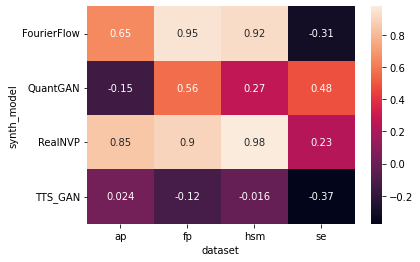

In [67]:
sns.heatmap(
    corrs_agg.pivot_table(index="synth_model", columns="dataset", values="correlation", aggfunc=np.mean),
    annot=True
)
plt.show()

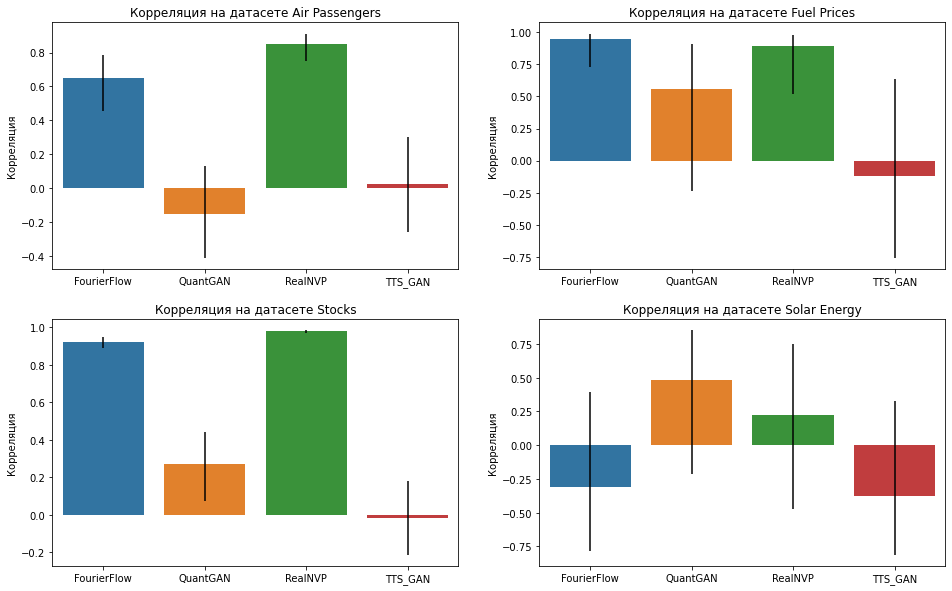

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i, dsname in enumerate(corrs_agg.dataset.unique()):
    loc_data = corrs_agg[corrs_agg.dataset == dsname]
    sns.barplot(data=loc_data, x="synth_model", y="correlation",\
        yerr=(loc_data["correlation"] - loc_data["low_bound"], loc_data["high_bound"] - loc_data["correlation"]), ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title("Корреляция на датасете " + {"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}[dsname])
    axs[i // 2][i % 2].set_xlabel("")
    axs[i // 2][i % 2].set_ylabel("Корреляция")

Deviation

In [69]:
devs = []  # deviation
ds_lens = {"hsm": 100, "se": 10, "fp": 8, "ap": 50}
for model in ("LSTM", "TCN"):#, "CBR"):
    for res_type in ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            # deviation
            dev = np.mean(np.abs(results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]] /\
                results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]] - 1)) * 100
            devs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "deviation": dev,})
devs = pd.DataFrame(devs)
devs

,model,synth_model,dataset,deviation
0,LSTM,QuantGAN,hsm,53.445334
1,LSTM,QuantGAN,se,235.494512
2,LSTM,QuantGAN,fp,35.092686
3,LSTM,QuantGAN,ap,34.365153
4,LSTM,RealNVP,hsm,6.461886
5,LSTM,RealNVP,se,34.308967
6,LSTM,RealNVP,fp,9.620908
7,LSTM,RealNVP,ap,198.398834
8,LSTM,FourierFlow,hsm,21.249033
9,LSTM,FourierFlow,se,228.346956


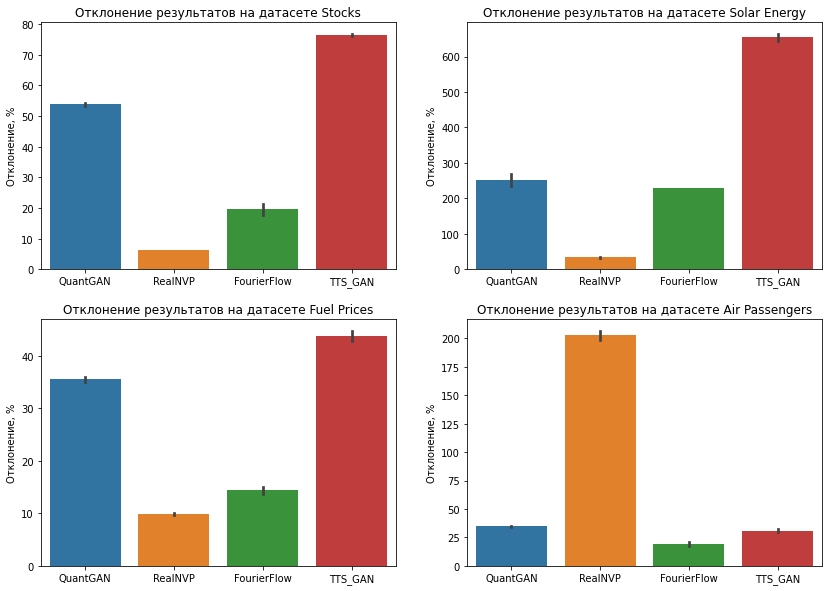

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
ds_name_extension = {"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}
for i, dataset in enumerate(("hsm", "se", "fp", "ap")):
    sns.barplot(data=devs[devs.dataset == dataset], x="synth_model", y="deviation", ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title(f"Отклонение результатов на датасете {ds_name_extension[dataset]}")
    axs[i // 2][i % 2].set_ylabel("Отклонение, %")
    axs[i // 2][i % 2].set_xlabel("")